In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadSAR"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.simple_synthetic_array_beamformer_processor import SyntheticArrayBeamformerProcessor
from mmwave_radar_processing.plotting.plotter_synthetic_array_data_simple import PlotterSyntheticArrayData
from mmwave_radar_processing.plotting.movies_synthetic_array_data import MovieGeneratorSyntheticArrayData
from mmwave_radar_processing.detectors.CFAR import CaCFAR_1D

/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz_lr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

print(cfg_manager.range_res_m)
print(cfg_manager.range_max_m)
print(cfg_manager.profile_cfgs)
print(cfg_manager.frameCfg_loops)

0.13657211975555555
12.291490778
[{'profileId': 0, 'startFreq_GHz': 77.0, 'idleTime_us': 300.0, 'adcStartTime_us': 7.0, 'rampEndTime_us': 100.0, 'txOutPower': 0.0, 'txPhaseShifter': 0.0, 'freqSlope_MHz_us': 25.0, 'txStartTime_us': 1.0, 'adcSamples': 90, 'sampleRate_kSps': 2050, 'hpfCornerFreq1': 0, 'hpfCornerFreq2': 0, 'rxGain_dB': 30.0}]
100


In [3]:
#load the dataset
dataset_name = "cpsl_radvel_test_1_sar"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="front_radar_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

found 760 radar samples
did not find lidar samples
did not find camera samples
did not find hand tracking samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 760 vehicle velocity samples
found 760 vehicle odometry samples


In [4]:
processor = SyntheticArrayBeamformerProcessor(
    config_manager=cfg_manager,
    az_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-90,stop=90,num=90
                 )),
    el_angle_bins_rad=np.array([0]),
    chirp_cfg_idx=0,
    stride=1,
    receiver_idx = 0,
    min_vel=0.2,
    max_vel_change=0.05,
)

synthetic_array_plotter = PlotterSyntheticArrayData(
    config_manager=cfg_manager,
    processor_SABF=processor,
    min_vel=0.2
)

movie_generator = MovieGeneratorSyntheticArrayData(
    cpsl_dataset=dataset,
    plotter=synthetic_array_plotter,
    processor=processor,
    temp_dir_path=os.path.join("~/Downloads/syntheticArraysProc",dataset_name)
)

found temp dir: /home/david/Downloads/syntheticArraysProc/cpsl_radvel_test_1_sar
clearing temp directory /home/david/Downloads/syntheticArraysProc/cpsl_radvel_test_1_sar


In [5]:
idx = 0
while not processor.array_geometry_valid:
    vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
    #convert into ned
    ned_vel_data = np.array([
        vel_data[0],
        -vel_data[1],
        -vel_data[2]
    ])
    processor.generate_array_geometries(ned_vel_data)
    idx += 1

print(idx)

215


In [6]:
# # speed test
# for i in tqdm(range(idx,dataset.num_frames)):
#     vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
#     processor.generate_array_geometries(vel_data)

#     #get the adc cube
#     adc_cube = dataset.get_radar_data(i)
#     #compute the response
#     resp = processor.process(adc_cube)

vel_data: [-0.00107412 -0.22464254  0.00125014]
ned_vel_data: [-0.00107412 -0.22464254  0.00125014]


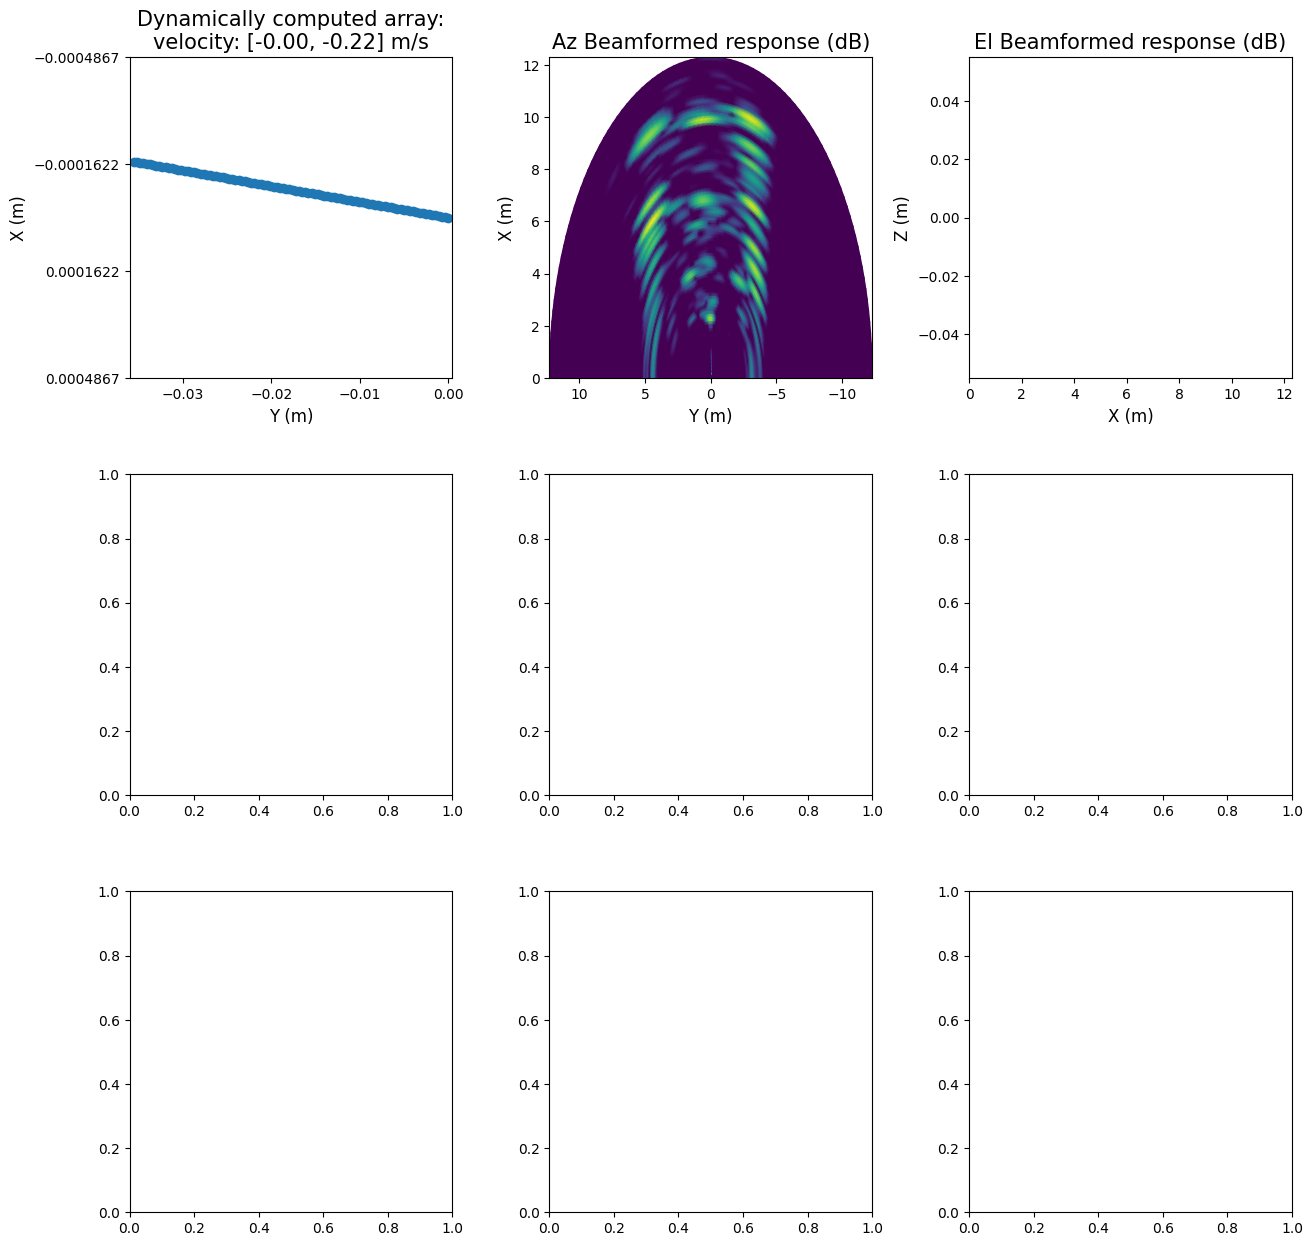

In [7]:
#get the velocity of the vehicle
idx = 216
# vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)

#convert into ned
ned_vel_data = np.array([
    vel_data[0],
    vel_data[1],
    vel_data[2]
])
print(f"vel_data: {vel_data}")
print(f"ned_vel_data: {ned_vel_data}")

#generate the array geometry
processor.generate_array_geometries(
    vels=ned_vel_data
)
#get the adc cube
adc_cube = dataset.get_radar_data(idx)
#compute the response
resp = processor.process(adc_cube)
#get the lidar pointcloud for gt comparison
try:
    lidar_pc_raw = dataset.get_lidar_point_cloud_raw(idx)
except AssertionError:
    lidar_pc_raw = np.empty(shape=(0))

# camera_view = dataset.get_camera_frame(idx)
try:
    camera_view = dataset.get_camera_frame(idx)
except AssertionError:
    camera_view = np.empty(shape=(0))

synthetic_array_plotter.plot_compilation(
    adc_cube=adc_cube,
    vels=ned_vel_data,
    camera_view=camera_view,
    lidar_pc_raw=lidar_pc_raw,
    lidar_radar_offset_rad=np.deg2rad(90),
    convert_to_dB=True,
    cmap="viridis",
    show=True
)

In [8]:
#generate the movie
# movie_generator.initialize_figure(nrows=2,ncols=3,figsize=(15,10))

# movie_generator.generate_movie_frames(
#     cmap="viridis",
#     convert_to_dB=True,
#     lidar_radar_offset_rad=np.deg2rad(90)
# )

# fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
# movie_generator.save_movie(video_file_name="{}_uav.mp4".format(dataset_name),fps=fps)

### Looking at the results for the original beamforming technique

In [9]:
#copy the adc cube to not modify the original
adc_cube_reshaped = adc_cube.copy()

#filter the adc cube for only the relevant chirps
adc_cube_reshaped = adc_cube_reshaped[processor.receiver_idx,:,:] #filter for specific receiver
adc_cube_reshaped = adc_cube_reshaped[:,processor.valid_chirps_mask] #filter for valid chirps


#reshape the adc cube further
adc_cube_reshaped = np.reshape(
        adc_cube_reshaped,
        (adc_cube_reshaped.shape[0],-1),
        order="F"
    )

#compute the range ffts
window = np.reshape(np.hanning(processor.num_range_bins),(processor.num_range_bins,-1))
windowed_signal = window * adc_cube_reshaped
freq_resps = np.fft.fft(windowed_signal,axis=0)

### Looking at the results for a modified beamforming technique

Indices of the 5 highest peaks: [54 75 72 59 39]
Values of the 5 highest peaks: [72.90131552 71.94213498 71.01369279 69.50519232 69.31628784]


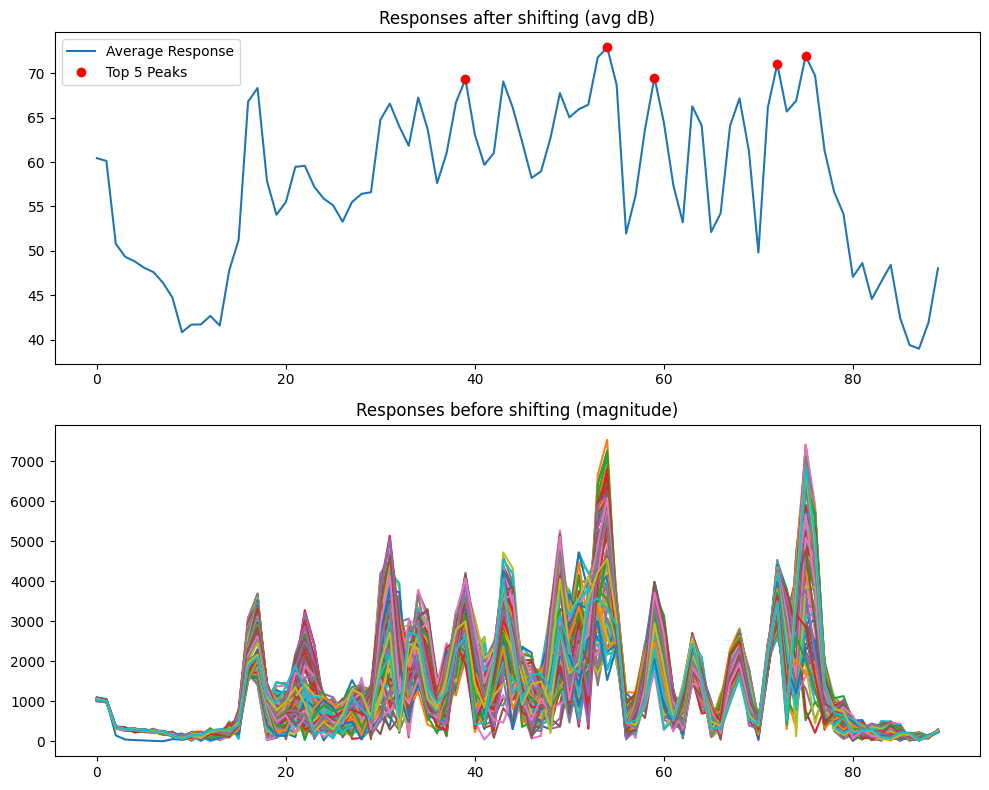

In [10]:
from scipy.signal import find_peaks

avg_resp = np.mean(20 * np.log10(np.abs(freq_resps)), axis=1)
# Find the peaks using scipy
peak_indices, _ = find_peaks(avg_resp, height=0)  # height=0 ensures we find all peaks
peak_values = avg_resp[peak_indices]

# Sort the peaks by their values in descending order and get the top 5
sorted_peak_indices = peak_indices[np.argsort(peak_values)[-5:][::-1]]
sorted_peak_values = avg_resp[sorted_peak_indices]

print(f"Indices of the 5 highest peaks: {sorted_peak_indices}")
print(f"Values of the 5 highest peaks: {sorted_peak_values}")

# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the average response with peaks in the first subplot
axs[0].plot(avg_resp, label="Average Response")
axs[0].plot(sorted_peak_indices, sorted_peak_values, "ro", label="Top 5 Peaks")
axs[0].set_title("Responses after shifting (avg dB)")
axs[0].legend()

# Plot the responses before shifting in the second subplot
axs[1].plot(np.abs(freq_resps))
axs[1].set_title("Responses before shifting (magnitude)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Indices of the top 2 peaks: [36 58]
Values of the top 2 peaks: [53.0939705  51.05563758]


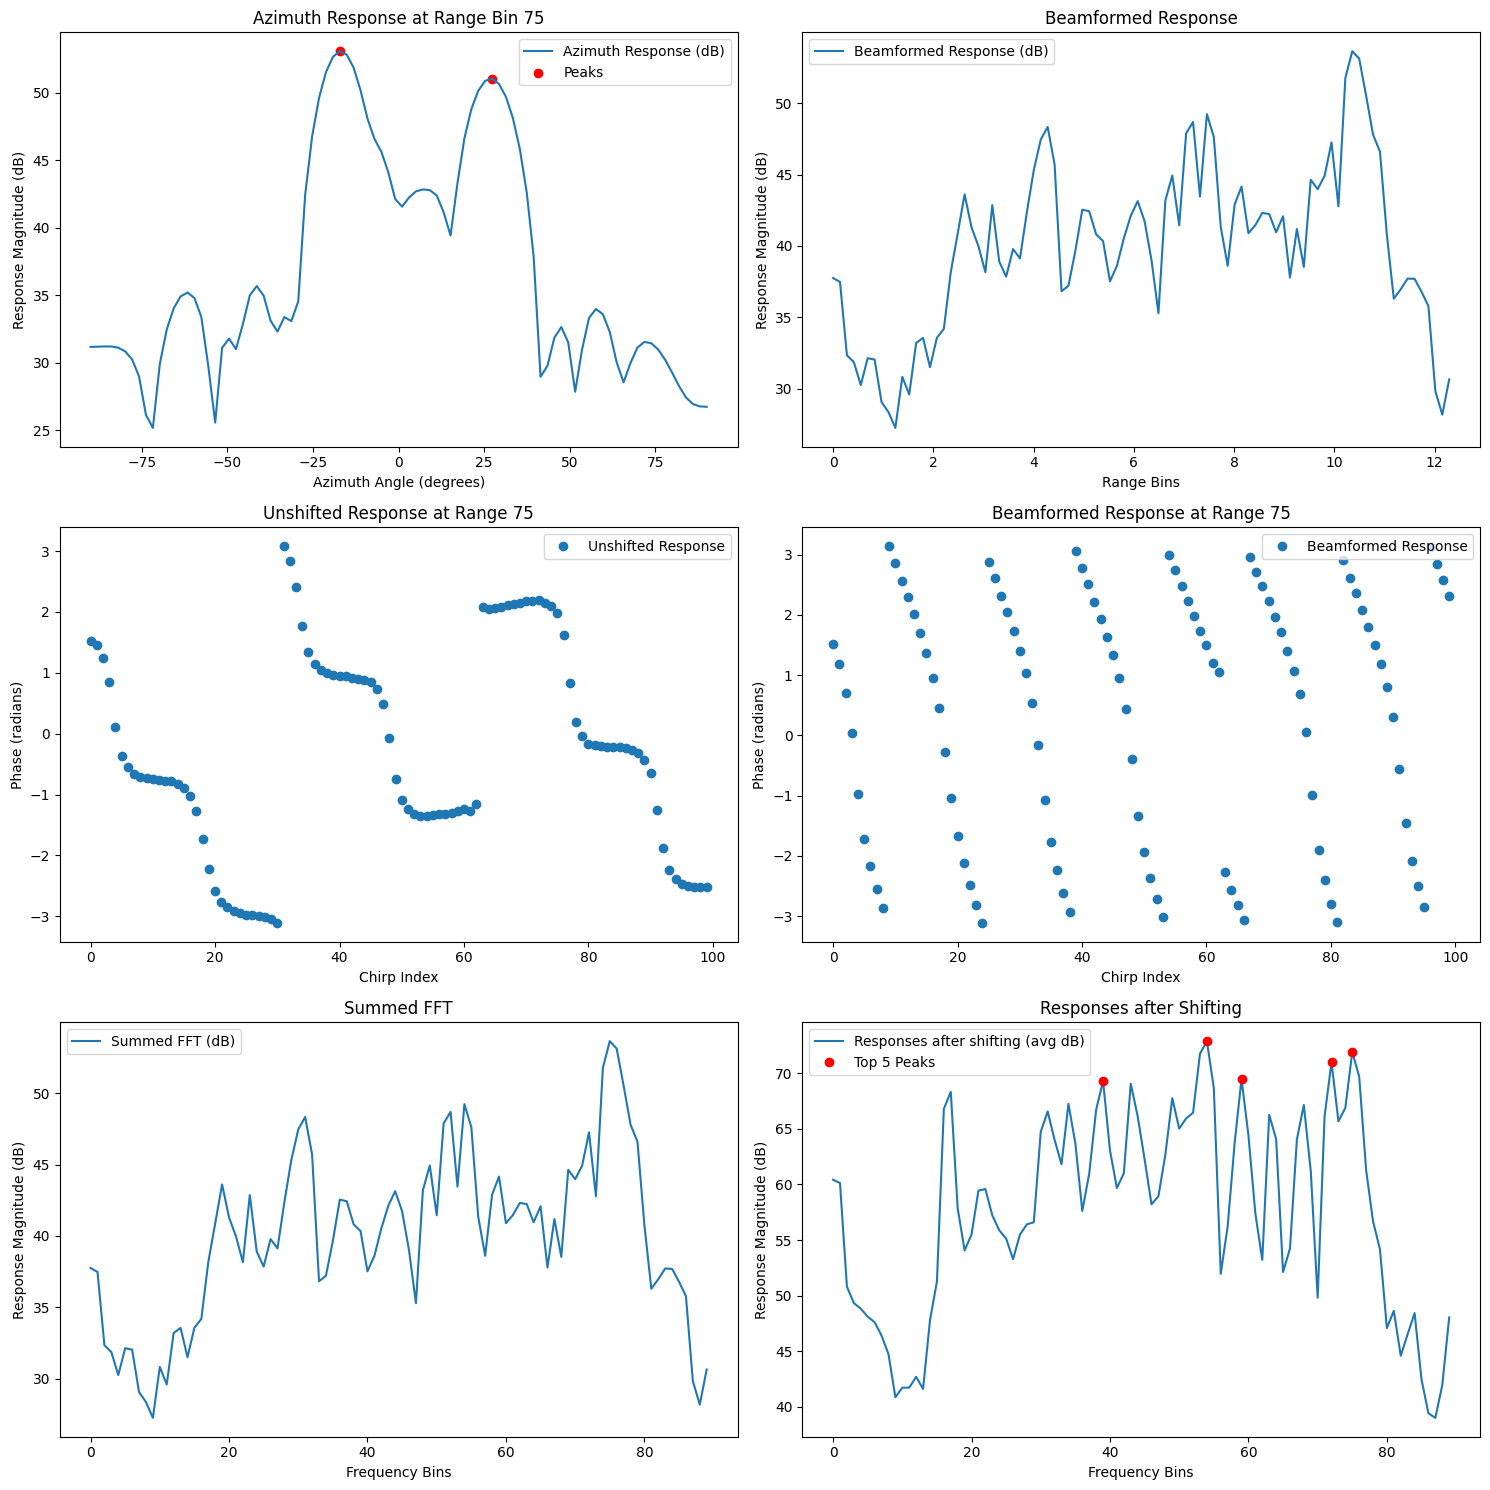

In [11]:
from scipy.signal import find_peaks

#compute the az response at a specific range bin
rng_idx = 75
az_idx = 58
el_idx = 0
freq_resp_at_rng = 10 * np.log10(np.abs(processor.beamformed_resp[rng_idx, :, 0]))
az_angle_bins_rad = np.rad2deg(processor.az_angle_bins_rad)  # Convert azimuth angle bins to degrees

# Find the peaks in the response
peaks, _ = find_peaks(np.abs(freq_resp_at_rng), height=0)  # height=0 ensures we find all peaks
peak_values = np.abs(freq_resp_at_rng)[peaks]

# Sort the peaks by their values in descending order and get the top 2
top_2_indices = peaks[np.argsort(peak_values)[-2:][::-1]]
top_2_values = peak_values[np.argsort(peak_values)[-2:][::-1]]

print(f"Indices of the top 2 peaks: {top_2_indices}")
print(f"Values of the top 2 peaks: {top_2_values}")

#steering vector
steering_vector = processor.d[:,az_idx,el_idx]

#compute the phase shift to apply to each received signal
shifts = np.exp(
    1j * 2 * np.pi * \
    (steering_vector @ processor.p) / processor.lambda_m)
shifts = np.reshape(shifts,(1,shifts.shape[0]))

#compute the beamformed response
beamformed_resps = np.multiply(adc_cube_reshaped,shifts)
beamformed_resp = np.sum(beamformed_resps,axis=1)

#compute the window
window = np.hanning(processor.num_range_bins)
beamformed_resp = np.fft.fft(window * beamformed_resp)

shifted_resps = np.multiply(freq_resps,shifts)


fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot 1: Azimuth Response at Range Bin
axs[0, 0].plot(az_angle_bins_rad, freq_resp_at_rng, label="Azimuth Response (dB)")
axs[0, 0].scatter(az_angle_bins_rad[top_2_indices], top_2_values, color='red', label="Peaks")
axs[0, 0].set_xlabel("Azimuth Angle (degrees)")
axs[0, 0].set_ylabel("Response Magnitude (dB)")
axs[0, 0].set_title("Azimuth Response at Range Bin {}".format(rng_idx))
axs[0, 0].legend()

# Plot 2: Beamformed Response (dB)
axs[0, 1].plot(processor.range_bins, 10 * np.log10(np.abs(beamformed_resp)), label="Beamformed Response (dB)")
axs[0, 1].set_xlabel("Range Bins")
axs[0, 1].set_ylabel("Response Magnitude (dB)")
axs[0, 1].set_title("Beamformed Response")
axs[0, 1].legend()

# Plot 3: Unshifted Response at Range
axs[1, 0].plot(np.angle(freq_resps[rng_idx]), "o", label="Unshifted Response")
axs[1, 0].set_title("Unshifted Response at Range {}".format(rng_idx))
axs[1, 0].set_xlabel("Chirp Index")
axs[1, 0].set_ylabel("Phase (radians)")
axs[1, 0].legend()

# # Plot 4: Beamformed Response at Range
axs[1, 1].plot(np.angle(shifted_resps[rng_idx]), "o", label="Beamformed Response")
axs[1, 1].set_title("Beamformed Response at Range {}".format(rng_idx))
axs[1, 1].set_xlabel("Chirp Index")
axs[1, 1].set_ylabel("Phase (radians)")
axs[1, 1].legend()

# Plot 5: Summed FFT (dB)
axs[2, 0].plot(10 * np.log10(np.abs(beamformed_resp)), label="Summed FFT (dB)")
axs[2, 0].set_title("Summed FFT")
axs[2, 0].set_xlabel("Frequency Bins")
axs[2, 0].set_ylabel("Response Magnitude (dB)")
axs[2, 0].legend()

# Plot 6: Responses after and before shifting
axs[2, 1].plot(avg_resp, label="Responses after shifting (avg dB)")
axs[2, 1].plot(sorted_peak_indices, sorted_peak_values, "ro", label="Top 5 Peaks")
axs[2, 1].set_title("Responses after Shifting")
axs[2, 1].set_xlabel("Frequency Bins")
axs[2, 1].set_ylabel("Response Magnitude (dB)")
axs[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
